<a href="https://colab.research.google.com/github/xsinxxer/starters/blob/main/Bert_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#First fine-tuning BERT then interpreting

In [1]:
pip install o

In [2]:
pip install os

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [3]:
import os

In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import o
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'imdb-dataset-of-50k-movie-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F134715%2F320111%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240528%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240528T163026Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D51e7481167f7e3d5e919126accdd0ab3bd34566eda454facb11a48c4381429725cebf64bd0dc3e9f59093838c8b0e8b343d659b67aac7a158ef4d8c5f8f9cd78b1d82c7adc6da1714eb0ae2be8a5e55898d532f293c2512bc3fda5fcd0d3e650dd8f986b15900c09403bbf9e14271bbc9247f7047c51ca30ee7f3de74c3cedc6545956bcc43c2141d5045814f3e7b9248c74ecd8cd686afd741c08a8d1e1824296dd1cef8113334d5efbed8618acfa2e1fb9c1b88b5d88f3cf639eb67769081f38902a483f0c33d64f5113dc40f4688c97ede466d01bf835de19bf47095ac4ec2602c3a12043762fae1cb5d1692c373b6ce2d5abc48aa298df019feaab94392a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 26962657 bytes downloaded
Downloaded and uncompressed: imdb-dataset-of-50k-movie-reviews
Data source import complete.


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [6]:
import tensorflow as tf
import sklearn
from tqdm import tqdm
df=pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df.sample()#.sample also a thing

,review,sentiment
12784,"Awful, awful, awful.<br /><br />A condescendin...",negative


In [ ]:
# Installing Transformers library
# !pip install transformers

In [7]:
# Loading the BERT Classifier and Tokenizer along with Input module
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")#has its own classifiers for sequence classification
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")#main model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#multiple as per data

In [9]:
def cat2num(value):
    if value=='positive':
        return 1
    else:
        return 0

df['sentiment']  =  df['sentiment'].apply(cat2num)
train = df[:45000]
test = df[45000:]

# Data Preprocessing
For training model with BERT, we need to do some additional Prepriocessing. Let's understand them one by one!
* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

In [10]:
# But first see BERT tokenizer exmaples and other required stuff!

example='In this Kaggle notebook, I will do sentiment analysis using BERT with Huggingface'
tokens=tokenizer.tokenize(example)
token_ids = tokenizer.convert_tokens_to_ids(tokens)#sep. func.
print(tokens)
print(token_ids)

['in', 'this', 'ka', '##ggle', 'notebook', ',', 'i', 'will', 'do', 'sentiment', 'analysis', 'using', 'bert', 'with', 'hugging', '##face']
[1999, 2023, 10556, 24679, 14960, 1010, 1045, 2097, 2079, 15792, 4106, 2478, 14324, 2007, 17662, 12172]


### Special Tokens
* [SEP] - marker for ending of a sentence
* [CLS] - we must add this token to the start of each sentence, so BERT knows we’re doing classification
* [PAD] -There is also a special token for padding:
* [UNK] - ERT understands tokens that were in the training set. Everything else can be encoded using the [UNK] (unknown) token

1. — ***convert_data_to_examples***: This will accept our train and test datasets and convert each row into an InputExample object.
2. — ***convert_examples_to_tf_dataset***: This function will tokenize the InputExample objects, then create the required input format with the tokenized objects, finally, create an input dataset that we can feed to the model.


In [11]:
def convert_data_to_examples(train, test, review, sentiment):
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[review],
                                                          label = x[sentiment]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[review],
                                                          label = x[sentiment]), axis = 1,)

    return train_InputExamples, validation_InputExamples

train_InputExamples, validation_InputExamples = convert_data_to_examples(train,  test, 'review',  'sentiment')


In [12]:
train_InputExamples[0]

InputExample(guid=None, text_a="One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appe

#making it bert-ready

In [13]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in tqdm(examples):
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,    # Add 'CLS' and 'SEP'
            max_length=max_length,    # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],input_dict["token_type_ids"], input_dict['attention_mask'])
        features.append(InputFeatures( input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label) )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'review'
LABEL_COLUMN = 'sentiment'

#tqdm is always a good idea

In [18]:
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

  0%|          | 0/45000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 45000/45000 [04:08<00:00, 180.97it/s]


In [19]:
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

100%|██████████| 5000/5000 [00:26<00:00, 191.61it/s]


In [ ]:
## Our dataset containing processed input sequences are ready to be fed to the model.

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
    336/Unknown - 359s 801ms/step - loss: 0.3674 - accuracy: 0.8333

KeyboardInterrupt: 

In [184]:
pred_sentences = ['worst movie of my life, will never watch movies from this series', 'Wow, blew my mind, what a movie by Marvel, animation and story is amazing']

In [185]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')   #tokenizing before sending!
tf_outputs = model(tf_batch)#direct output
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)#softmax..-1 means argmax actually
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()#to array
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": ", labels[label[i]])

worst movie of my life, will never watch movies from this series :  Negative
Wow, blew my mind, what a movie by Marvel, animation and story is amazing :  Positive


Working,now saving

In [39]:
from transformers import TFBertForSequenceClassification
model.save_pretrained('my_saved_model2')

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
saved_model_path = '/content/my_saved_model2'
!cp -r {saved_model_path} /content/drive/MyDrive/

Accessing

In [16]:
from transformers import TFBertForSequenceClassification
saved_model_path = '/content/drive/MyDrive/my_saved_model2'
model = TFBertForSequenceClassification.from_pretrained(saved_model_path)
print(model)

Some layers from the model checkpoint at /content/drive/MyDrive/my_saved_model2 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/my_saved_model2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [19]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [124]:
import numpy as np
import tensorflow as tf

def get_gradients(text, model, tokenizer):
    def get_correct_span_mask(correct_index, token_size):
        span_mask = np.zeros((1, token_size))
        span_mask[0, correct_index] = 1
        span_mask = tf.constant(span_mask, dtype='float32')
        return span_mask
    embedding_matrix = model.bert.embeddings.weights[0]
    encoded_tokens = tokenizer(text, return_tensors="tf")
    token_ids = list(encoded_tokens["input_ids"].numpy()[0])
    vocab_size = embedding_matrix.get_shape()[0]
    token_ids_tensor = tf.constant([token_ids], dtype='int32')
    token_ids_tensor_one_hot = tf.one_hot(token_ids_tensor, vocab_size)
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(token_ids_tensor_one_hot)
        inputs_embeds = tf.matmul(token_ids_tensor_one_hot, embedding_matrix)
        pred_scores = model({"inputs_embeds": inputs_embeds, "attention_mask": encoded_tokens["attention_mask"]}).logits
        max_class = tf.argmax(pred_scores, axis=1).numpy()[0]
        score_mask = get_correct_span_mask(max_class, pred_scores.shape[1])
        predict_correct_class = tf.reduce_sum(pred_scores * score_mask)
        #gradient_non_normalized = tf.norm(tape.gradient(predict_correct_class, token_ids_tensor_one_hot),axis = 2)
        gradients = tape.gradient(predict_correct_class, token_ids_tensor_one_hot)
        gradient_non_normalized = tf.norm(gradients, axis=2)
        #Normalize gradient scores
        gradient_tensor = (
            gradient_non_normalized /
            tf.reduce_max(gradient_non_normalized)
        )#divides by max!
        gradients = gradient_tensor[0].numpy().tolist()
        token_words = tokenizer.convert_ids_to_tokens(token_ids)

        prediction_label = "positive" if max_class == 1 else "negative"

    return gradients, token_words, prediction_label


In [172]:
text = "A brilliant movie, I expect to watch the second season too!"

gradients, token_words, prediction_label = get_gradients(text, model, tokenizer)
#print("Tokenized Words:", token_words)
#print("Gradients:", gradients.shape)
mul = 1 if prediction_label == "positive" else -1
grad = np.array(gradients)

In [142]:
print(mul)

-1


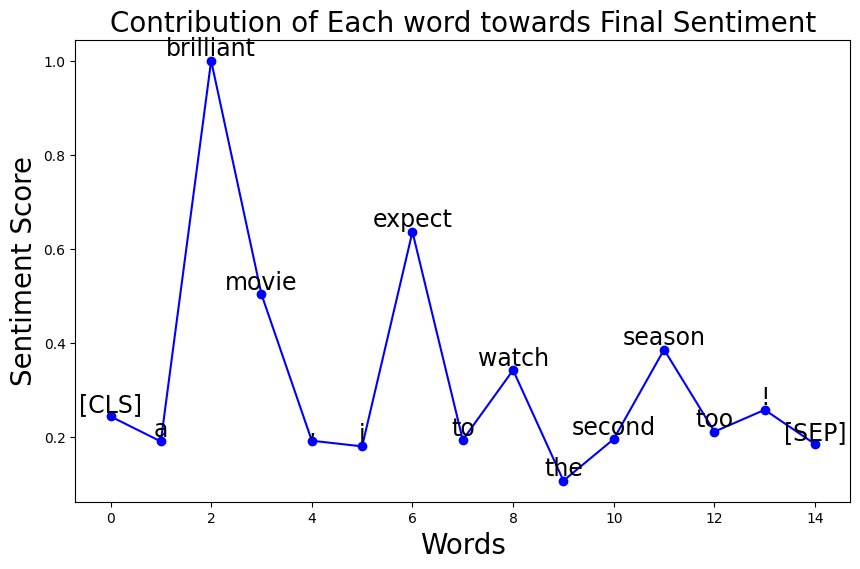

A brilliant movie, I expect to watch the second season too!
Predicted Sentiment: positive


In [173]:
plt.figure(figsize=(10,6))
plt.plot(grad*mul, marker='o', linestyle='-', color='b')
for i, word in enumerate(token_words):
    plt.text(i, grad[i]*mul, word, fontsize=17, ha='center', va='bottom', rotation=0)

plt.title('Contribution of Each word towards Final Sentiment',fontsize=20)
plt.xlabel('Words',fontsize=20)
plt.ylabel('Sentiment Score',fontsize=20)
plt.grid(False)
plt.show()
print(text)
print("Predicted Sentiment:", prediction_label)

In [192]:
model2 = model

# This model unknwoingly wasnt made for attention weights,lets import original bert model

In [212]:
import torch
from transformers import BertTokenizer, BertModel
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_attentions=True)  # Ensure output_attentions=True
text = "The acting was brilliant."
inputs = tokenizer(text, return_tensors='pt')
outputs = model(**inputs)
attention = outputs.attentions

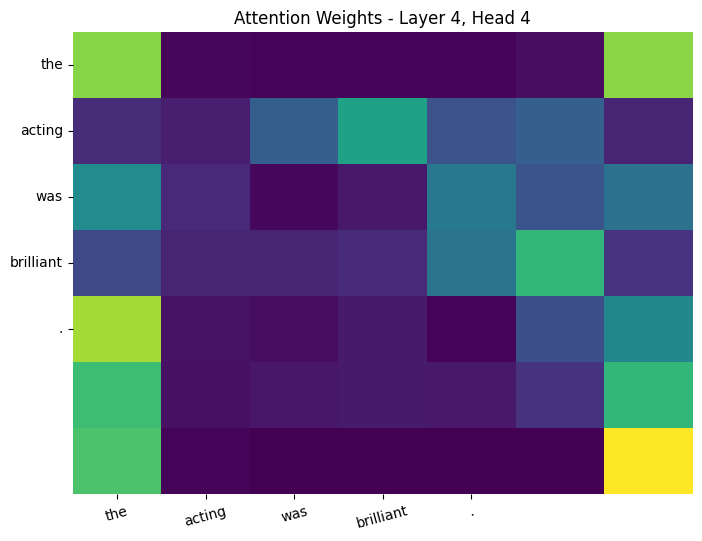

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#weights for 4th head and 4th layer
attention_np = [layer.detach().numpy() for layer in attention]
layer_idx = 3
head_idx = 3
attention_layer_head = attention_np[layer_idx][0, head_idx]
tokens = tokenizer.tokenize(text)
plt.figure(figsize=(8, 6))
sns.heatmap(attention_layer_head, cmap="viridis", cbar=False)
plt.xticks(np.arange(len(tokens)) + 0.5, tokens, rotation=15, fontsize=10)
plt.yticks(np.arange(len(tokens)) + 0.5, tokens, rotation=0, fontsize=10)
plt.title(f"Attention Weights - Layer {layer_idx + 1}, Head {head_idx + 1}")
plt.show()


# Each word attentively attends to the word "the" ; we also see "brilliant" word correlates well with word "acting" [ROW-2,COL-4]